# 이시국 검사기

세상이 어쩌다 이지경이 됐을까?
2020년에는 마스크 끼면서 집에서 유튜브 보다가 다 지나게 생겼습니다.

화가 납니다.
다들 마스크 좀 잘 끼고 손 잘 씻고 다녔으면,
이 사단이 진작에 끝이 날 수 있었습니다.

그런데 뭐, 사람 사는 세상이 다 그렇지 않나요.
사람은 너무 약한 동물이고,
누구는 까먹어서 혹은 누구는 고의적으로 마스크를 끼지 않는 경우도 많습니다.

그런데 적어도, 제 주변에서는 이런 경우가 적었으면 좋겠습니다.
그래서 만들었습니다.
마스크를 착용하지 않은 사람들을 색출해내는,
이시국 검사기!

Copyright 2020. `Ho Kim`. All rights reversed, For education only.

## Setup

이시국 검사기는 딥러닝으로 만들 겁니다.
특히, 요즘에 성능이 잘나오는 [yolov5](https://github.com/ultralytics/yolov5)를 사용하겠습니다.

이 튜토리얼 또한, 이 사람들이 만든 아래의 튜토리얼을 따라 만들었습니다.
* https://github.com/ultralytics/yolov5/blob/master/tutorial.ipynb

In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -qr yolov5/requirements.txt  # install dependencies (ignore errors)
%cd yolov5

import torch
from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.6.0+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


## GPU 자원 검사

이시국 검사기는 성능 좋은 GPU를 사용해 학습하겠습니다.
아래의 연산을 수행한다면, Google Colab에서 사용 가능한 GPU의 목록이 표시됩니다.

만약, GPU가 제대로 표시되지 않다면,
메뉴의 Runtime-Change runtime type 에서 GPU를 선택해 다시 실행해주세요.

In [2]:
!nvidia-smi

Tue Oct 13 23:57:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 객체인식 테스트

일단, 딥러닝으로 객체인식을 하는 예시를 보여드리겠습니다.

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', img_size=416, iou_thres=0.5, output='inference/output', save_txt=False, source='inference/images/', update=False, view_img=False, weights=['yolov5s.pt'])
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

100% 14.5M/14.5M [00:00<00:00, 21.2MB/s]

Fusing layers... 
Model Summary: 140 layers, 7.45958e+06 parameters, 0 gradients
image 1/2 /content/yolov5/inference/images/bus.jpg: 416x352 3 persons, 1 buss, Done. (0.028s)
image 2/2 /content/yolov5/inference/images/zidane.jpg: 288x416 2 persons, 1 ties, Done. (0.020s)
Results saved to inference/output
Done. (0.491s)


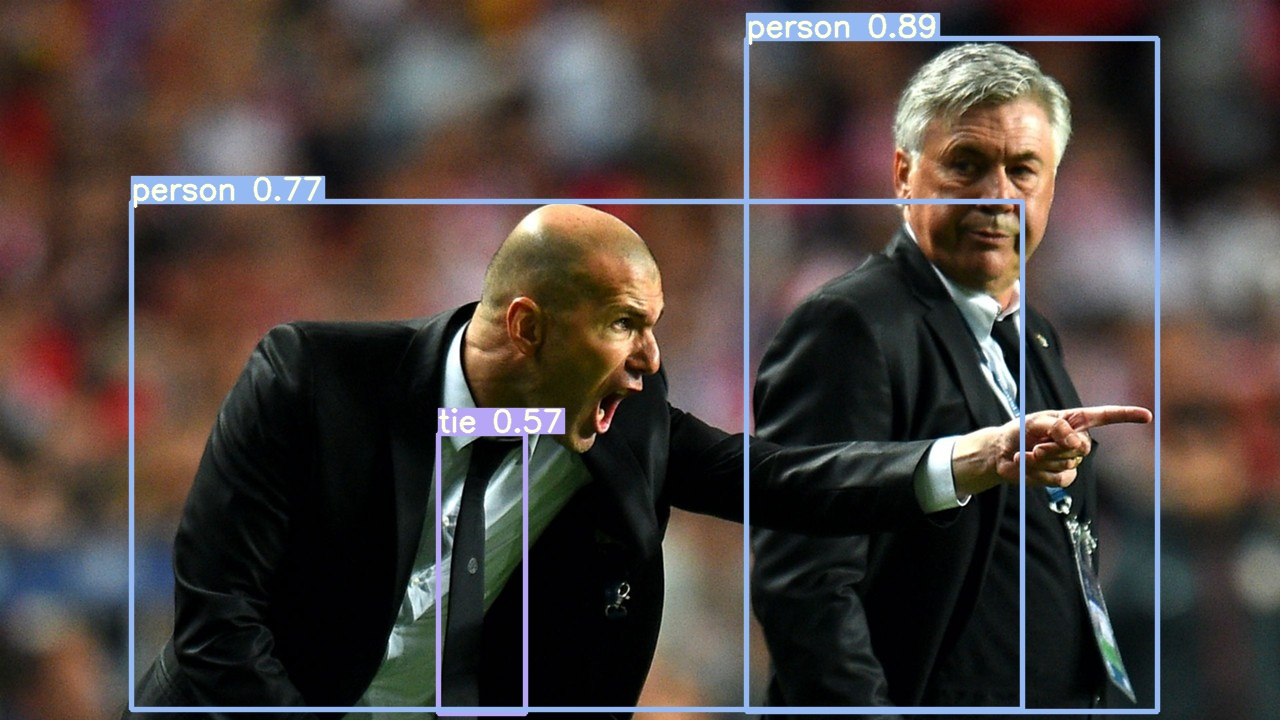

In [3]:
!python detect.py --weights yolov5s.pt --img 416 --conf 0.4 --source inference/images/
Image(filename='inference/output/zidane.jpg', width=600)

![성능 확실하구만](http://img.battlepage.com/upload/2020/0903/0320260191a07365fccc5aa6e25bfb0713171d98.png)

## 데이터셋 가져오기

마스크를 쓴 사람, 대충 쓴 사람, 쓰지 않은 사람의 사진 묶음이 담긴 데이터셋을 다운로드합니다.

아래의 kaggle 사이트에서 다운로드 후, 필요한 기능을 추가하였습니다.
* https://www.kaggle.com/andrewmvd/face-mask-detection

이 데이터셋은 해당 프로젝트 외의 사용을 금합니다.

In [4]:
gdrive_download('1Ff6i4Ryz8xXYn5wKoSIP98-7QUZk79ZZ', 'masks.zip')

0

## 데이터셋 가공하기

`Yolov5` 가 사용 가능한 데이터 형식에 맞춰줍니다.

In [5]:
!mkdir masks
!mv origin to_yolov5.py yolov5s_masks.yaml masks

!cd masks; python to_yolov5.py

yolov5/masks 디렉토리에 데이터셋이 구성되었습니다.

## 모델 학습하기

이제, `yolov5`에게 이시국 검사기를 학습시켜보겠습니다.
꽤 오래 걸릴 겁니다.

`Google Colab`은 12시간동안 무료 GPU를 제공하는 좋은 사이트입니다.
12시간이 지나더라도, 다시 접속해서 다시 실행하면 그만입니다.

다만, 90분동안 아무 행동이 없으면 세션이 종료됩니다.
즉, 이 딥러닝 학습이 90분 이상일 때, 나도 모르게 학습이 되다 마는 겁니다.

이 문제의 해결 방법이 아래의 사이트에 잘 나와있습니다.
* https://somjang.tistory.com/entry/Google-Colab-%EC%9E%90%EC%A3%BC%EB%81%8A%EA%B8%B0%EB%8A%94-%EB%9F%B0%ED%83%80%EC%9E%84-%EB%B0%A9%EC%A7%80%ED%95%98%EA%B8%B0

In [6]:
!python train.py --img 640 --weights '' --epochs 300 --batch 64 --data masks/data.yaml --cfg masks/yolov5s_masks.yaml

Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

Namespace(adam=False, batch_size=64, bucket='', cache_images=False, cfg='masks/yolov5s_masks.yaml', data='masks/data.yaml', device='', epochs=300, evolve=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[640, 640], local_rank=-1, logdir='runs/', multi_scale=False, name='', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, sync_bn=False, total_batch_size=64, weights='', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/", view at http://localhost:6006/
2020-10-13 23:58:18.162166: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Hyperparameters {'lr0': 0.01, 'lrf': 0.2, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'box': 0.05, 'cls': 0.5, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1

## 성능 평가하기

이제, 학습한 이시국 검사기의 성능을 한번 보겠습니다~

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', img_size=640, iou_thres=0.5, output='inference/output', save_txt=False, source='masks/images/val/maksssksksss104.png', update=False, view_img=False, weights=['yolov5s_masks.pt'])
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

Fusing layers... 
Model Summary: 140 layers, 7.25191e+06 parameters, 0 gradients
image 1/1 /content/yolov5/masks/images/val/maksssksksss104.png: 448x640 6 without_masks, 3 with_masks, Done. (0.012s)
Results saved to inference/output
Done. (0.065s)


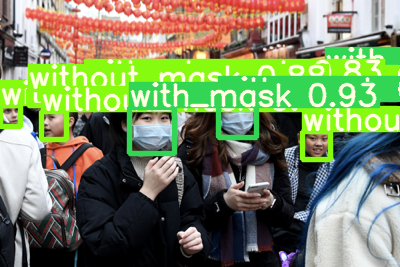

In [7]:
!cp runs/exp0/weights/best.pt yolov5s_masks.pt 
!python detect.py --source masks/images/val/maksssksksss104.png --weights yolov5s_masks.pt
Image(filename='inference/output/maksssksksss104.png', width=600)

![성능 확실하구만](http://img.battlepage.com/upload/2020/0903/0320260191a07365fccc5aa6e25bfb0713171d98.png)

## 모델 변환하기

`PyTorch`로 학습한 모델을 `Tflite` 포맷으로 변환하겠습니다.
다만, 바로 변환할 수는 없고,
`ONNX`, `Tensorflow` 포맷을 거쳐서 변환이 됩니다.

In [8]:
!pip install onnx coremltools
!pip install git+https://github.com/onnx/onnx-tensorflow.git
clear_output()

# ONNX 포맷으로 변환
!python models/export.py --weights yolov5s_masks.pt --img 640 --batch 1
clear_output()

# Tensorflow 포맷으로 변환
!onnx-tf convert -i "yolov5s_masks.onnx" -o  "yolov5s_masks.pb"
clear_output()

# Tflite 포맷으로 변환
import tensorflow as tf

converter = tf.compat.v1.lite.TFLiteConverter.from_saved_model('yolov5s_masks.pb')
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
tf_lite_model = converter.convert()
open('yolov5s_masks.tflite', 'wb').write(tf_lite_model)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from yolov5s_masks.pb/variables/variables
INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'__saved_model_init_op', 'serving_default'}
INFO:tensorflow:input tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: images
INFO:tensorflow: tensor name: serving_default_images:0, shape: (1, 3, 640, 640), type: DT_FLOAT
INFO:tensorflow:output tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: output_0
INFO:tensorflow: tensor name: StatefulPartitionedCall:0, shape: (1, 3, 80, 80, 8), type: DT_FLOAT
INFO:tensorflow:Tensor's key in saved_model's tensor_map: output_1
INFO:tensorflow: tensor name: StatefulPartitionedCall:1, shap

29099832

## 모델 다운로드하기

마지막으로, 학습한 이시국 검사기 가중치 뭉치를 다운로드하겠습니다.

In [9]:
from google.colab import files
files.download('yolov5s_masks.tflite') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>